### FE630 - Midterm Project

**Author**: Sid Bhatia

**Date**: March 25th, 2023

**Pledge**: I pledge my honor that I have abided by the Stevens Honor System.

**Professor**: Papa Momar Ndiaye

##### Question 1. (15 pts)

The supplied $\texttt{data.zip}$ file contains 30 space-delimited text files that contain price and volume data for 30 companies. Each row of each file contains date, opening price, closing price, high price, low price, volume, and adjusted closing price (last column). You will need that data for question 1. 

Write a program $\texttt{processdata}$ to:

1. Read all daily price files;
2. Create a price matrix $\texttt{P}$ by aligning the data’s dates and placing the adjusted closing prices side-by-side in columns;
3. From the $\texttt{P matrix}$, create a matrix of simple (not logarithmic) daily returns $\texttt{R}$;
4. Compute the vector of average daily returns mu for the companies using the $\texttt{mean}$ function (do not use loops);
5. Compute the covariance matrix $\texttt{Q}$ from the return matrix using the $\texttt{cov}$ function; and
6. Save the return vector $\texttt{mu}$ and the covariance matrix $\texttt{Q}$ in the native format for your programming language in a file called $\texttt{inputs.ext}$, where $\texttt{ext}$ is the appropriate extension for a binary file in your language.

In [4]:
import pandas as pd
import numpy as np
import os
from typing import List

def processdata(data_dir: str = 'data') -> None:
    """
    Processes stock price data to compute and save the average daily return vector and covariance matrix.
    
    This function reads stock price data from text files, each containing data for a company, then:
    1. Creates a price matrix with adjusted close prices,
    2. Calculates the daily return matrix,
    3. Computes the vector of average daily returns for each company,
    4. Computes the covariance matrix of the return matrix,
    5. Saves the average daily returns vector and the covariance matrix to binary files.
    
    Parameters:
    - data_dir (str): The directory containing the stock price files. Default is 'data'.
    
    Returns:
    - None. The function saves two files: 'inputs_mu.pkl' and 'inputs_Q.pkl' with the results.
    """
    # List to store the adjusted close price data for each company.
    price_data: List[pd.Series] = []

    # Loop through each file in the specified directory.
    for file in os.listdir(data_dir):
        if file.endswith('.txt'):
            filepath = os.path.join(data_dir, file)
            # Read data, assuming space-separated values without an explicit header.
            df = pd.read_csv(filepath, sep=' ', header=None,
                             names=['Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'Adj Close'])
            # Set date as the index for easy alignment later.
            df.set_index('Date', inplace=True)
            # Append the adjusted close price series to the list.
            price_data.append(df['Adj Close'])

    # Concatenate all the adjusted close prices side-by-side, aligning by date.
    P = pd.concat(price_data, axis=1)
    P.sort_index(inplace=True)  # Ensure the dates are in order.

    # Calculate daily returns by comparing each price with the previous day's price.
    R = P.pct_change().dropna()  # Drop the first row since its percentage change is undefined.

    # Calculate the vector of average daily returns for each company.
    mu = R.mean(axis=0)

    print(mu)

    # Calculate the covariance matrix of the daily returns.
    Q = R.cov()

    print(Q)

    # Save the vector of average daily returns and the covariance matrix as binary files.
    mu.to_pickle('inputs_mu.pkl')
    Q.to_pickle('inputs_Q.pkl')

processdata()

Adj Close    0.000225
Adj Close    0.000473
Adj Close    0.000945
Adj Close    0.000540
Adj Close   -0.000340
Adj Close    0.000563
Adj Close   -0.000295
Adj Close    0.000339
Adj Close    0.001099
Adj Close    0.000425
Adj Close    0.001033
Adj Close    0.001010
Adj Close   -0.000270
Adj Close    0.000669
Adj Close    0.000521
Adj Close    0.000637
Adj Close    0.000240
Adj Close    0.000290
Adj Close    0.000705
Adj Close    0.000468
Adj Close    0.000901
Adj Close    0.000491
Adj Close    0.000233
Adj Close    0.000139
Adj Close    0.000595
Adj Close    0.001255
Adj Close    0.000200
Adj Close    0.000226
Adj Close    0.000022
Adj Close   -0.000107
dtype: float64
           Adj Close  Adj Close  Adj Close  Adj Close  Adj Close  Adj Close   
Adj Close   0.000342   0.000079   0.000080   0.000097   0.000104   0.000069  \
Adj Close   0.000079   0.000144   0.000066   0.000088   0.000062   0.000051   
Adj Close   0.000080   0.000066   0.000169   0.000076   0.000058   0.000056   
Adj Close

##### Question 2. (15 pts)

Write a function called $\texttt{port}$ that uses standard quadratic programming libraries that will:

- Take the set of input parameters $\texttt{mu}$ (mean vector $\mu$), $\texttt{Q}$ (covariance matrix $Q$), and $\texttt{tau}$ (risk tolerance $\tau$), and return vector $h$ that maximizes the following utility function $U$ defined by: $$U(h) = -\frac{1}{2}h^T Q h + \tau h^T \mu$$ subject to the constraints $$0 \leq h_i \leq 0.1 \; \text{for all} \; i, \; \text{and}$$ $$\sum_{i=1}^n h_i = h^T e = 1$$ where $n$ is the number of securities in the portfolio.

In [5]:
import cvxpy as cp

def port(mu: np.ndarray, Q: np.ndarray, tau: float) -> np.ndarray:
    """
    Solves the portfolio optimization problem to maximize the utility function
    under given constraints using quadratic programming.
    
    Parameters:
    - mu (np.ndarray): The mean return vector for the securities.
    - Q (np.ndarray): The covariance matrix of the securities' returns.
    - tau (float): The risk tolerance parameter of the utility function.
    
    Returns:
    - h (np.ndarray): The optimized portfolio weights vector.
    """
    
    # Number of securities
    n = mu.shape[0]
    
    ## print(n)
    
    # Portfolio weights variable
    h = cp.Variable(n)

    ## print(h)

    # Define utility function to maximize.
    utility = -0.5 * cp.quad_form(h, Q) + tau * cp.matmul(h.T, mu)

    ## print(utility)

    # Constraints: 0 <= h_i <= 0.1 for all i, and sum(h_i) == 1
    constraints = [0 <= h, h <= 0.1, cp.sum(h) == 1]

    ## print(constraints)

    # Problem definition
    problem = cp.Problem(cp.Maximize(utility), constraints)
    
    # Solve the problem.
    problem.solve()
    
    # Return the optimized portfolio weights.
    return h.value

##### Question 3. (15 pts)

Write a program called $\texttt{frontier}$ that will:

1. Load in your programming environment the data stored in the $\texttt{inputs.ext}$;
2. Create a sequence $\texttt{TAU}$ containing numbers from zero to 0.5 in steps of 0.001;
3. Run through a loop for each value of your $\texttt{TAU}$ sequence to
- Find the optimum portfolio with the given $\texttt{m}$, $\texttt{Q}$, and $\texttt{tau}$ selected from $\texttt{TAU}$;
- Compute the optimum portfolio’s expected return and standard deviation of return;
- Store the portfolio return and standard deviation.
4. After completing the loop, plot the efficient frontier.

In [6]:
import matplotlib.pyplot as plt

def load_inputs(mu_path: str = 'inputs_mu.pkl', Q_path: str = 'inputs_Q.pkl') -> (np.ndarray, np.ndarray): # type: ignore
    """
    Loads the mean returns vector and covariance matrix from the specified files.
    
    Parameters:
    - mu_path (str): Path to the file containing the mean returns vector.
    - Q_path (str): Path to the file containing the covariance matrix.
    
    Returns:
    - tuple: A tuple containing the mean returns vector and the covariance matrix.
    """
    mu = pd.read_pickle(mu_path).values
    Q = pd.read_pickle(Q_path).values
    return mu, Q

def compute_metrics(mu: np.ndarray, Q: np.ndarray, h: np.ndarray) -> (float, float): # type: ignore
    """
    Computes the expected return and standard deviation of the portfolio.
    
    Parameters:
    - mu (np.ndarray): The mean return vector for the securities.
    - Q (np.ndarray): The covariance matrix of the securities' returns.
    - h (np.ndarray): The portfolio weights.
    
    Returns:
    - tuple: A tuple containing the expected return and standard deviation of the portfolio.
    """
    expected_return = np.dot(mu.T, h)
    std_dev = np.sqrt(np.dot(h.T, np.dot(Q, h)))
    return expected_return, std_dev    

def frontier():
    """
    Plots the efficient frontier by optimizing portfolios over a range of risk tolerance values using the `port` function.
    Loads mean returns vector and covariance matrix, then calculates and plots the efficient frontier.
    """
    # Load the mean returns vector and covariance matrix from saved files.
    mu, Q = load_inputs()
    TAU = np.arange(0, 0.501, 0.001)  # Range of risk tolerance values
    returns = []  # List to store expected returns of optimized portfolios
    std_devs = []  # List to store standard deviations of optimized portfolios

    for tau in TAU:
        # Use the previously defined port() function for portfolio optimization.
        h_opt = port(mu, Q, tau)
        # Compute expected return and standard deviation for the optimized portfolio.
        ret, std = compute_metrics(mu, Q, h_opt)
        # Store the results.
        returns.append(ret)
        std_devs.append(std)

    # Plot the efficient frontier.
    plt.figure(figsize=(10, 6))
    plt.plot(std_devs, returns, 'o-', markersize=4)
    plt.title('Efficient Frontier')
    plt.xlabel('Standard Deviation of Portfolio Return')
    plt.ylabel('Expected Portfolio Return')
    plt.grid(True)
    plt.show()

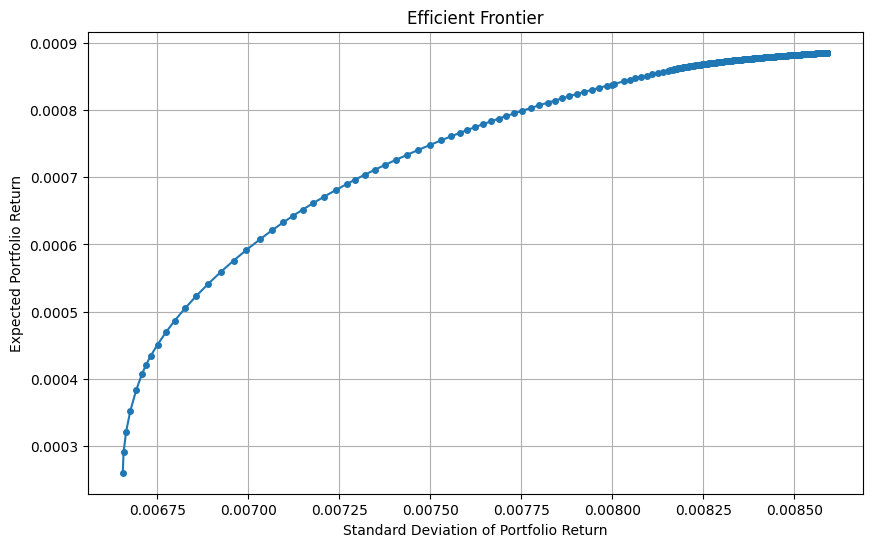

In [7]:
frontier()

The supplied $\texttt{Midtermdata.zip}$ file contains an $\bf{R}$ data file $\texttt{data.rda}$ and a tab-delimited text file $\texttt{data.tsv}$ containing the Dow-Jones Industrial Index and the closing prices for the 30 companies in that index for 250 trading days. **You will use that data for questions 4, 5 and 6.**

##### Question 4. (15 pts)

Write a program to:
1. read in this Dow-Jones data,
2. convert the matrix of daily prices to daily simple returns (not logarithmic returns),
3. annualize the returns by multiplying them by 252 (the typical number of trading days in a year),
4. move the index column out of the matrix and into a separate vector,
5. compute a covariance matrix $\texttt{Qts}$ based on the time-series of returns, and
6. print out the first five rows and five columns of the covariance matrix.

Clearly describe all steps in your program with comments. List your program in your answer document. No points will be awarded unless the steps associated with each part of the question are clearly distinguished. Also, submit the source code file.

##### *Step 1.*

In [8]:
def read_data(file_path: str) -> pd.DataFrame:
    """
    Reads the data from a tab-delimited text file into a pandas DataFrame.

    Parameters:
    - file_path (str): The path to the data file.

    Returns:
    - pd.DataFrame: A DataFrame with the Dow-Jones data.
    """
    # Try to read the data with tab as delimiter; if that fails, try to infer the delimiter.
    try:
        data = pd.read_csv(file_path, delimiter='\t')
    except pd.errors.ParserError:
        data = pd.read_csv(file_path, delimiter=None, engine='python')
    
    # Check if the data has been read into separate columns, otherwise raise an error.
    if data.shape[1] == 1:
        raise ValueError("Data is not being read into separate columns. Check the delimiter.")
    
    # Convert the first column to datetime and set it as the index.
    data.iloc[:, 0] = pd.to_datetime(data.iloc[:, 0], errors='coerce')
    data.set_index(data.columns[0], inplace=True)
    
    return data

def read_data(file_path: str) -> pd.DataFrame:
    """
    Reads the data from a comma-delimited text file into a pandas DataFrame, 
    setting the first row as the header and the first column as a DateTime index.

    Parameters:
    - file_path (str): The path to the data file.

    Returns:
    - pd.DataFrame: A DataFrame with the Dow-Jones data, with correct column names and a DateTime index.
    """
    # Read the file, explicitly mentioning that the first row should be used as the header
    data = pd.read_csv(file_path, header=0)
    
    # Correctly set the first column's name and use it as the index
    # Assuming the first column contains the date in 'YYYYMMDD' format and needs conversion to DateTime type
    data.columns = ['Date'] + [f'{col}' for col in data.columns[1:]]  # Rename columns to fix 'Unnamed: X' issue
    data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')  # Convert the 'Date' column to DateTime
    data.set_index('Date', inplace=True)  # Set the 'Date' column as the index
    
    return data

##### *Step 2.*

In [118]:
def calculate_simple_returns(prices: pd.DataFrame) -> pd.DataFrame:
    """
    Converts a matrix of daily prices to daily simple returns.

    Parameters:
    - prices (pd.DataFrame): A DataFrame with daily prices.

    Returns:
    - pd.DataFrame: A DataFrame with daily simple returns.
    """
    # Calculate daily simple returns.
    returns = prices.pct_change().dropna()  # Drop the first row as the return for the first day is not defined.
    return returns

##### *Step 3.*

In [119]:
def annualize_returns(returns: pd.DataFrame) -> pd.DataFrame:
    """
    Annualizes the daily simple returns.

    Parameters:
    - returns (pd.DataFrame): A DataFrame with daily simple returns.

    Returns:
    - pd.DataFrame: A DataFrame with annualized returns.
    """
    # Multiply by the number of trading days to annualize.
    annual_returns = returns * 252
    return annual_returns

##### *Step 4.*

In [120]:
from typing import Tuple

def extract_index(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Moves the index column out of the DataFrame into a separate vector.

    Parameters:
    - data (pd.DataFrame): A DataFrame with the index as one of the columns.

    Returns:
    - Tuple[pd.DataFrame, pd.Series]: A tuple of the DataFrame without the index column and the index column as a Series.
    """
    # Assuming the index is the first column, we separate it from the data.
    index_column = data.iloc[:, 0]
    data_without_index = data.iloc[:, 1:]
    return data_without_index, index_column

##### *Step 5.*

In [121]:
def compute_covariance_matrix(returns: pd.DataFrame) -> pd.DataFrame:
    """
    Computes the covariance matrix based on the time-series of returns.

    Parameters:
    - returns (pd.DataFrame): A DataFrame with annualized returns.

    Returns:
    - pd.DataFrame: The covariance matrix of the returns.
    """
    # Compute the covariance matrix.
    Qts = returns.cov()
    return Qts

##### *Step 6.*

In [2]:
# file_path = 'Midtermdata/data.tsv'
# file_path = 'Midtermdata/data.csv'

# # Step 1: Read in the data.
# data = read_data(file_path)

# print(data.head())

# # Step 2 and 3: Convert to simple returns and annualize.
# daily_prices = data.drop(columns=data.columns[0])  # Drop the first column if it's an index column.

# print(daily_prices)

# daily_returns = calculate_simple_returns(daily_prices)
# annual_returns = annualize_returns(daily_returns)

# # Step 4: Move the index column out of the matrix.
# data_without_index, index_column = extract_index(data)

# # Step 5: Compute the covariance matrix.
# Qts = compute_covariance_matrix(annual_returns)

# # Step 6: Print the first five rows and columns of the covariance matrix.
# print(Qts.iloc[:5, :5])

##### Implementation in R

The following section implements the same concepts as above but in R as parsing the data was easier and more efficient in R.

```r
library(tidyverse)
library(lubridate)

# Function to read the data and set the first column as a DateTime index
read_data <- function(file_path) {
  # Read the data, assuming the first row is the header
  data <- read.csv(file_path, header = TRUE)
  
  # Convert the first column to Date format assuming it's in 'YYYYMMDD' format
  # Assuming the first column is named 'Date' or similar; adjust accordingly
  data[,1] <- ymd(data[,1])
  
  # Set the first column as row names if needed or keep as a separate Date column
  # Optionally, you can make the date column as row names (not always recommended for time series data in R)
  # rownames(data) <- data[,1]
  # data <- data[,-1]
  
  return(data)
}

# Function to calculate simple returns
calculate_simple_returns <- function(prices) {
  returns <- prices / lag(prices) - 1
  returns <- na.omit(returns)  # Remove NA values resulted from lagging
  return(returns)
}

# Function to annualize returns
annualize_returns <- function(returns) {
  annual_returns <- returns * 252
  return(annual_returns)
}

# Function to compute the covariance matrix
compute_covariance_matrix <- function(returns) {
  Qts <- cov(returns)
  return(Qts)
}
```

##### Pre-Processing

```r
# Step 1: Read in the data
file_path <- "Midtermdata/data.csv"

# Read the CSV file, making sure the first row is used as column names.
data <- read.csv(file_path, header = TRUE, check.names = FALSE)

# Set the value in the first row, first column to "Date"
data[1, 1] <- "Date"

# Now, use the first row to set column names and remove the first row from the data
colnames(data) <- as.character(unlist(data[1, ]))
data <- data[-1, ]

# Assuming 'data' is your dataframe and 'Date' is the column with dates in YYYYMMDD format
data$Date <- as.Date(as.character(data$Date), format="%Y%m%d")

# Assuming the first column is the date, and the rest are the prices
data[,-1] <- sapply(data[,-1], as.numeric)

head(data)
```


```r
# dates <- data[[1]] # Extract the first column as dates
# prices <- data[-1] # Remove the first column from the data
# 
# # Convert the first column to dates if it's not already
# dates <- as.Date(as.character(dates), format="%Y%m%d")

# Step 2: Calculate daily returns.
daily_returns <- data[, -1] / lag(data[, -1]) - 1
daily_returns <- daily_returns[-1, ]  # Remove the first row which will be NA.

print(head(daily_returns))

# Step 3: Annualize the daily returns.
annual_returns <- apply(daily_returns, 2, mean, na.rm = TRUE) * 252

print(annual_returns)

# Step 4: Extract the index column.
## Already did in pre-processing.

# Step 5: Compute the covariance matrix of daily returns.
Qts <- cov(daily_returns, use = "pairwise.complete.obs")

# Step 6: Print out the first five rows and columns of the covariance matrix.
print(Qts[1:5, 1:5])
```

The table below shows the annualized returns for selected stocks:

| Ticker | Annualized Return |
| ------ | ----------------- |
| ^DJI   | 4.91%             |
| AAPL   | 12.34%            |
| AXP    | -13.92%           |
| BA     | 22.56%            |
| CAT    | -27.28%           |
| CSCO   | 24.10%            |
| CVX    | -20.34%           |
| DD     | 0.44%             |
| DIS    | 28.20%            |
| GE     | 20.38%            |
| GS     | 3.93%             |
| HD     | 30.27%            |
| IBM    | -7.88%            |
| INTC   | 8.08%             |
| JNJ    | -1.32%            |
| JPM    | 12.55%            |
| KO     | 8.23%             |
| MCD    | 24.77%            |
| MMM    | 7.65%             |
| MRK    | -0.56%            |
| MSFT   | 21.98%            |
| NKE    | 39.47%            |
| PFE    | 19.97%            |
| PG     | -6.73%            |
| TRV    | 16.45%            |
| UNH    | 27.39%            |
| UTX    | -1.26%            |
| V      | 41.52%            |
| VZ     | -1.20%            |
| WMT    | -23.16%           |
| XOM    | -9.78%            |

Below is the covariance matrix for a subset of the stocks:

```plaintext
             ^DJI         AAPL          AXP           BA          CAT
^DJI 8.873133e-05 1.010457e-04 7.573449e-05 9.047886e-05 9.436840e-05
AAPL 1.010457e-04 2.706878e-04 8.131692e-05 1.278212e-04 1.181664e-04
AXP  7.573449e-05 8.131692e-05 1.858309e-04 5.841554e-05 7.909844e-05
BA   9.047886e-05 1.278212e-04 5.841554e-05 1.823244e-04 9.310019e-05
CAT  9.436840e-05 1.181664e-04 7.909844e-05 9.310019e-05 2.454428e-04
```

##### Question 5. (20 pts)

Given $n$ securities $S_i, (i = 1, \dots, 30),$ the single index model for their securities’ returns is given by $$r_i = \alpha_i + \beta_i r_M + \epsilon_i$$ where $r_M$ is the return of the Index (here the Dow Jones), $\epsilon_i$ is a random variable specific to Security $S_i$ satisfies $$\mathbb{E}[\epsilon_i] = 0, \; cov(\epsilon_i, r_M) = 0, \; \text{if} \; i \neq j$$ where $\sigma^2_M$ is the variance of the Index, and $\sigma^2_{R_i}$ is the variance of the residual $\epsilon_i$ for security $S_i$.

Write a program utilizing the Dow-Jones data that:
1. uses a loop to regress each company’s returns onto the index return,
2. prints a table of intercepts, slopes ($\beta_i$), and idiosyncratic standard deviations $\sigma_{R_i}$ (standard deviation of the residuals) for all companies $i = 1, \dots, 30$,
3. computes and prints the variance of the index’s return,
4. computes and prints the variance of the index’s return, $\texttt{Qts}$ using your computed $\sigma^2_M$, $\beta_i$, and $\sigma^2_{R_i}$, for all $i$, and
5. prints the first five rows and columns of this covariance matrix.

Clearly describe all steps in your program with comments. List your program in your answer document. No points will be awarded unless the steps associated with each part of the question are clearly distinguished. Also, submit the source code file.

##### Implementation in R

```r
# 0. Pre-process the Data: Already done, moving to regression

# Step 1. Conduct the regressional analysis
results <- list() # To store regression results

for(i in 3:ncol(data)){
  # Using backticks to handle special characters in column names
  formula <- as.formula(paste("`", colnames(data)[i], "` ~ `", colnames(data)[2], "`", sep = ""))
  reg <- lm(formula, data = data)
  alpha_i <- coef(reg)[1] # Intercept
  beta_i <- coef(reg)[2] # Slope
  sigma_R_i <- sd(residuals(reg)) # Standard deviation of residuals
  results[[colnames(data)[i]]] <- c(alpha_i, beta_i, sigma_R_i)
}

# Step 2. Creating a data frame from the results list for better visualization
results_df <- do.call(rbind, results)
colnames(results_df) <- c("Intercept", "Beta", "Sigma_R")
rownames(results_df) <- names(results)

print(results_df)

# Convert results_df into a data frame.
results_df <- as.data.frame(results_df)

# Step 2. Printing the results table
print(results_df)

# Step 3: Compute and print the variance of the index's return
sigma_M_squared <- var(data[,2]) # Assuming the 2nd column is the DJI
print(sigma_M_squared)

# Step 4. Compute the covariance matrix: Using formula sigma^2_M * Beta_i * Beta_j + delta_ij * sigma^2_Ri
## Here, delta_ij is the Kronecker delta, which is 1 if i = j and 0 otherwise
Qts <- matrix(nrow=30, ncol=30)

for(i in 1:nrow(results_df)){
  for(j in 1:nrow(results_df)){
    if(i == j){
      # Diagonal elements represent the variance for each security
      Qts[i,j] <- sigma_M_squared * (results_df$Beta[i]^2) + (results_df$Sigma_R[i]^2)
    } else {
      # Off-diagonal elements represent the covariances between securities
      Qts[i,j] <- sigma_M_squared * results_df$Beta[i] * results_df$Beta[j]
    }
  }
}

# 5. Print the first five rows and columns of the covariance matrix.
print(Qts[1:5, 1:5])
```

|       | Intercept   | Beta          | Sigma_R    |
|-------|-------------|---------------|------------|
| AAPL  | -44.113438  | 0.0092603548  | 5.9559090  |
| AXP   | 26.954988   | 0.0030676210  | 5.1682927  |
| BA    | -2.069516   | 0.0080176033  | 7.9228769  |
| CAT   | -57.771249  | 0.0079356594  | 6.7220955  |
| CSCO  | 1.308190    | 0.0014745322  | 0.9932658  |
| CVX   | -163.948667 | 0.0149088567  | 7.0677293  |
| DD    | -123.711973 | 0.0106266070  | 4.3608027  |
| DIS   | 40.224863   | 0.0035978044  | 8.4461406  |
| GE    | 13.754330   | 0.0006716579  | 1.2838192  |
| GS    | 10.463861   | 0.0103470463  | 9.2050610  |
| HD    | 158.959614  | -0.0027874917 | 7.2751732  |
| IBM   | -35.685778  | 0.0109893315  | 4.5309059  |
| INTC  | -2.378091   | 0.0019549064  | 2.2268284  |
| JNJ   | 33.855770   | 0.0037188064  | 2.6888608  |
| JPM   | 42.582072   | 0.0011015650  | 3.7680066  |
| KO    | 26.414590   | 0.0008046107  | 1.0557201  |
| MCD   | 110.504144  | -0.0008779753 | 3.9126782  |
| MMM   | -44.856342  | 0.0113798013  | 3.7119309  |
| MRK   | -6.222425   | 0.0035744999  | 1.9765850  |
| MSFT  | 34.345438   | 0.0006028535  | 2.3818999  |
| NKE   | 251.852456  | -0.0084191331 | 9.0603493  |
| PFE   | 17.980153   | 0.0008492355  | 1.6345089  |
| PG    | -31.305411  | 0.0063229560  | 4.4014649  |
| TRV   | 68.210986   | 0.0019608476  | 2.9911744  |
| UNH   | 122.943990  | -0.0005916892 | 8.9702680  |
| UTX   | -155.186100 | 0.0149959961  | 4.9281090  |
| V     | 93.184150   | -0.0014373705 | 3.8318563  |
| VZ    | 11.334647   | 0.0019956060  | 1.1132384  |
| WMT   | -70.942748  | 0.0083456221  | 5.8924571  |
| XOM   | -41.291564  | 0.0071211814  | 4.2129147  |

|       | ,1      | ,2      | ,3      | ,4      | ,5     |
|-------|-----------|-----------|-----------|-----------|----------|
| 1,  | 62.601606 | 8.986776  | 23.488040 | 23.247980 | 4.319729 |
| 2,  | 8.986776  | 29.688244 | 7.780739  | 7.701216  | 1.430970 |
| 3,  | 23.488040 | 7.780739  | 83.107894 | 20.128072 | 3.740016 |
| 4,  | 23.247980 | 7.701216  | 20.128072 | 65.108921 | 3.701791 |
| 5,  | 4.319729  | 1.430970  | 3.740016  | 3.701791  | 1.674410 |

##### Question 6. (20 pts)

With your function $\texttt{port}$ from the Question 2:

1. Use the set of input parameters $\texttt{mu}$ (mean vector $\mu$), $\texttt{Qts}$ (covariance matrix $Q$ computed with a time series approximation), and $\texttt{tau}$ (risk tolerance $\tau$) to compute the efficient frontier corresponding to the maximization of utility function $U$ defined by $$U(h) = -\frac{1}{2} h^T Q h + \tau h^T \mu$$ subject to the constraints $$0 \leq h_i \leq 0.1 \; \text{for all} \; i, \; \text{and}$$ $$\sum_{i = 1}^n h^T e = 1$$ where $n$ is the number of securities in the portfolio. Be  sure to include all constraints; both equality and inequality constraints.
2. Repeat the computation of the efficient frontier but now use the approximate covariance matrix $\texttt{Qts}$ from the single index model instead of the time-series model $\texttt{Qts}$.